In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xlsxwriter

In [ ]:
data = np.loadtxt('../data/eff_Bandbreite.txt', skiprows=1)
f = data[:,0]
f_err = 0.003 * f
U_in = data[:,1]
U_out = data[:,2]
U_in_err = 0.05 * U_in
U_out_err = 0.05 * U_out

G_exp = U_out / U_in
G_exp_err = np.sqrt( (U_out_err / U_in)**2 + ((U_out * U_in_err) / U_in**2)**2 )

def G_lp(f, f_l):
    return 1 / np.sqrt(1 + (f / f_l)**4)
def G_hp(f, f_h):
    return (f/f_h)**2 / np.sqrt(1 + (f / f_h)**4)

def G_total(f, f_l, f_h):
    return G_lp(f, f_l) * G_hp(f, f_h)

# Fit using curve_fit  
popt, pcov = curve_fit(G_total, # Model function to fit
                        f,                      # x-data
                        G_exp,                  # y-data
                        sigma=G_exp_err,        # Standard deviations of y-data
                        absolute_sigma=True,    # Use absolute errors
                        p0=[100, 10000],        # Initial guess for parameters 
                        bounds=([0, 0],[np.inf, np.inf]))       # bounds
f_l_fit, f_h_fit = popt     # Fitted parameters (array of best fit parameters that minimize chi-squared)
f_l_err, f_h_err = np.sqrt(np.diag(pcov))   # Standard deviations of the fitted parameters

# chi-squared calculation
residuals = (G_exp - G_total(f, *popt)) / G_exp_err
chi_squared = np.sum(residuals**2)
dof = len(f) - len(popt)  # degrees of freedom
reduced_chi_squared = chi_squared / dof

# effective bandwidth calculation
delta_f_eff = np.sqrt(2) * np.pi * f_l_fit**4 / (4 * (f_h_fit + f_l_fit) * (f_h_fit**2 + f_l_fit**2))


## data to excel
#df_test = pd.DataFrame({
#    'f (Hz)': f,
#    'f_err (Hz)': f_err,
#    'G_exp': G_exp,
#    'G_exp_err': G_exp_err,
#})
#df_test.to_excel('../data/test.xlsx', index=False)


In [6]:
# Results
for fi, Gi, erri in zip(f, G_exp, G_exp_err):
    print(f"f: {fi:.2f} Hz, G_exp: {Gi:.4f} ± {erri:.4f}")

print(f"\nFitted f_l: {f_l_fit:.2f} ± {f_l_err:.2f} Hz")
print(f"Fitted f_h: {f_h_fit:.2f} ± {f_h_err:.2f} Hz")
print(f"\nChi2: {chi_squared:.2f}, dof: {dof}, Reduced Chi2: {reduced_chi_squared:.2f}")
print(f"Effective Bandwidth Δf_eff: {delta_f_eff:.2f} Hz")

f: 2.00 Hz, G_exp: 0.0276 ± 0.0019
f: 5.00 Hz, G_exp: 0.0274 ± 0.0019
f: 8.00 Hz, G_exp: 0.0277 ± 0.0020
f: 20.00 Hz, G_exp: 0.0273 ± 0.0019
f: 50.00 Hz, G_exp: 0.0276 ± 0.0019
f: 80.00 Hz, G_exp: 0.0282 ± 0.0020
f: 200.00 Hz, G_exp: 0.0487 ± 0.0034
f: 500.00 Hz, G_exp: 0.2568 ± 0.0182
f: 800.00 Hz, G_exp: 0.5348 ± 0.0378
f: 2000.00 Hz, G_exp: 1.0155 ± 0.0718
f: 5000.00 Hz, G_exp: 0.9732 ± 0.0688
f: 8000.00 Hz, G_exp: 0.8445 ± 0.0597
f: 20000.00 Hz, G_exp: 0.2409 ± 0.0170
f: 50000.00 Hz, G_exp: 0.0464 ± 0.0033
f: 80000.00 Hz, G_exp: 0.0313 ± 0.0022
f: 200000.00 Hz, G_exp: 0.0278 ± 0.0020
f: 500000.00 Hz, G_exp: 0.0376 ± 0.0027
f: 800000.00 Hz, G_exp: 0.1276 ± 0.0090
f: 2000000.00 Hz, G_exp: 0.0606 ± 0.0043
f: 5000000.00 Hz, G_exp: 0.0265 ± 0.0019
f: 8000000.00 Hz, G_exp: 0.0262 ± 0.0018
f: 10000000.00 Hz, G_exp: 0.0306 ± 0.0022

Fitted f_l: 11152.76 ± 233.41 Hz
Fitted f_h: 892.55 ± 18.92 Hz

Chi2: 2455.07, dof: 20, Reduced Chi2: 122.75
Effective Bandwidth Δf_eff: 6429.89 Hz


In [7]:
# dataframes in latex format
# raw data
df_raw = pd.DataFrame({
    r'$f$ / Hz': f,
    r'$\mathrm{RMS}_{in}$ / V': U_in,
    r'$\mathrm{RMS}_{out}$ / V': U_out,
    r'G_{\text{exp}}': G_exp,
    r'\Delta G_{\text{exp}}': G_exp_err
})
print(df_raw.to_latex(index=False, float_format="%.3e"))

# fitted parameters
df_fit = pd.DataFrame({
    r'$f$ / Hz' : f,
    r'$G_{\text{exp}}$' : G_exp,
    r'$\Delta G_{\text{exp}}$' : G_exp_err
})
print(df_fit.to_latex(index=False, float_format="%.3e"))

\begin{tabular}{rrrrr}
\toprule
$f$ / Hz & $\mathrm{RMS}_{in}$ / V & $\mathrm{RMS}_{out}$ / V & G_{\text{exp}} & \Delta G_{\text{exp}} \\
\midrule
2.000e+00 & 7.510e+00 & 2.070e-01 & 2.756e-02 & 1.949e-03 \\
5.000e+00 & 7.490e+00 & 2.050e-01 & 2.737e-02 & 1.935e-03 \\
8.000e+00 & 7.500e+00 & 2.080e-01 & 2.773e-02 & 1.961e-03 \\
2.000e+01 & 7.460e+00 & 2.040e-01 & 2.735e-02 & 1.934e-03 \\
5.000e+01 & 7.440e+00 & 2.050e-01 & 2.755e-02 & 1.948e-03 \\
8.000e+01 & 7.400e+00 & 2.090e-01 & 2.824e-02 & 1.997e-03 \\
2.000e+02 & 7.120e+00 & 3.470e-01 & 4.874e-02 & 3.446e-03 \\
5.000e+02 & 7.400e+00 & 1.900e+00 & 2.568e-01 & 1.816e-02 \\
8.000e+02 & 7.480e+00 & 4.000e+00 & 5.348e-01 & 3.781e-02 \\
2.000e+03 & 7.110e+00 & 7.220e+00 & 1.015e+00 & 7.180e-02 \\
5.000e+03 & 7.470e+00 & 7.270e+00 & 9.732e-01 & 6.882e-02 \\
8.000e+03 & 7.460e+00 & 6.300e+00 & 8.445e-01 & 5.972e-02 \\
2.000e+04 & 7.430e+00 & 1.790e+00 & 2.409e-01 & 1.704e-02 \\
5.000e+04 & 7.420e+00 & 3.440e-01 & 4.636e-02 & 3.278e-03 \\

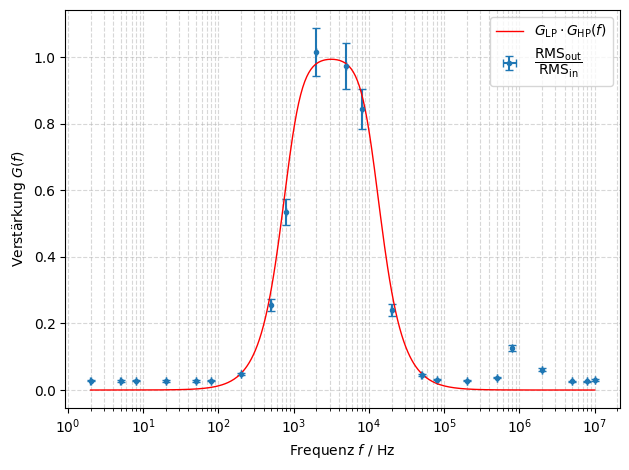

In [9]:
fig, ax = plt.subplots()
ax.errorbar(f, G_exp, 
            yerr=G_exp_err, 
            xerr=f_err, 
            fmt='.', 
            label=r'$\dfrac{\mathrm{RMS}_{\mathrm{out}}}{\mathrm{RMS}_{\mathrm{in}}}$',
            capsize=3)

f_fit = np.logspace(np.log10(min(f)), np.log10(max(f)), 500)
ax.plot(f_fit, G_total(f_fit, *popt), 
        'r-', 
        label=r'$G_{\mathrm{LP}}\cdot G_{\mathrm{HP}}(f)$', linewidth=1)
ax.set_xscale('log')

ax.set_xlabel(r'Frequenz $f$ / Hz')
ax.set_ylabel(r'Verstärkung $G(f)$')
ax.legend()
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.5)

plt.tight_layout()
#plt.savefig('../plots/eff_Bandbreite.pdf')
plt.show()